In [1]:
import torch
import numpy as np
import glob
import os
from os.path import join as opj
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import tqdm


## Load the dataset

In [2]:
data_path = "/srv/nfs-data/janeway/UDGSL_Dataset/HCP"

In [3]:
d_in = 25
ica = f"ica{d_in}"

In [4]:
file_list = glob.glob(opj(data_path,ica,"*.npy"))

In [34]:


class TimeSeriesDataset(Dataset):
    def __init__(self, file_list, scaling = 60):
        """
        Args:
            file_list (list of str): List of file paths to the .npy files.
        """
        self.file_list = file_list
        self.scaling = scaling

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get the file path
        file_path = self.file_list[idx]
        
        # Load the timeseries from .npy file
        timeseries = np.load(file_path)
        
        # Convert to PyTorch tensor
        timeseries_tensor = torch.tensor(timeseries, dtype=torch.float32).T/self.scaling
        
        # Extract the label from the file name
        file_name = os.path.basename(file_path)
        label_str = file_name.split('_')[1].replace('.npy', '')
        label = int(label_str)  # Convert label to integer
        
        return timeseries_tensor, label


In [35]:
train_dataset = TimeSeriesDataset(file_list[:800])
test_dataset = TimeSeriesDataset(file_list[800:])



In [22]:
x,y = next(iter(train_dataset))

## Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)  # Shape: (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        x: Tensor of shape (sequence_length, batch_size, d_model)
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class MaskedAutoencoder(nn.Module):
    def __init__(self, patch_size, d_in, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(MaskedAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.d_model = d_model  # Embedding dimension
        self.d_in = d_in
        
        # Shared Conv1d layer to project patches into embeddings
        self.encoder_projection = nn.Conv1d(in_channels=d_in, out_channels=d_model, kernel_size=patch_size)
        
        # Positional Encoding for the transformer
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # Projection back to time series using ConvTranspose1d
        self.decoder_projection = nn.ConvTranspose1d(
            in_channels=d_model,
            out_channels=d_in,
            kernel_size=patch_size
        )
        
    def patchify(self, x):
        batch_size, seq_len, d_in = x.shape
        ps = self.patch_size
        n_patches = seq_len // ps  # Number of full patches
        x = x[:, :n_patches * ps, :]  # Trim to fit full patches
        x_patches = x.view(batch_size, n_patches, ps, d_in)
        return x_patches
    
    def depatchify(self, x_patches):
        batch_size, n_patches, ps, d_in = x_patches.shape
        x_reconstructed = x_patches.view(batch_size, n_patches * ps, d_in)
        return x_reconstructed
    
    def mask_patches(self, x_patches, mask_ratio=0.5):
        batch_size, n_patches, ps, d_in = x_patches.shape
        num_masked_patches = int(mask_ratio * n_patches)
        
        # Generate random masks
        random_scores = torch.rand(batch_size, n_patches, d_in, device=x_patches.device)
        # Determine threshold for masking
        threshold = torch.kthvalue(random_scores, num_masked_patches, dim=1).values.unsqueeze(1)
        mask = (random_scores < threshold).float()
        
        # Apply mask
        mask_expanded = mask.unsqueeze(2)  # Shape: (batch_size, n_patches, 1, d_in)
        x_masked = x_patches.clone()
        x_masked = x_masked * (1 - mask_expanded)
        
        return x_masked, mask
    
    def forward(self, x, mask_ratio=0.5):
        # Patchify
        x_patches = self.patchify(x)  # Shape: (batch_size, n_patches, patch_size, d_in)
        # print(f'Patchified input shape: {x_patches.shape}')
        
        # Mask patches
        x_masked_patches, mask = self.mask_patches(x_patches, mask_ratio=mask_ratio)
        # print(f'Masked patches shape: {x_masked_patches.shape}')
        # print(f'Mask shape: {mask.shape}')
        
        batch_size, n_patches, ps, d_in = x_masked_patches.shape
        
        # Reshape for Conv1d
        x_patches_reshaped = x_masked_patches.view(batch_size * n_patches, ps, d_in)  # Shape: (batch_size * n_patches, patch_size, d_in)
        x_patches_reshaped = x_patches_reshaped.permute(0, 2, 1)  # Shape: (batch_size * n_patches, d_in, patch_size)
        
        # Apply Conv1d to project patches into embeddings
        embeddings = self.encoder_projection(x_patches_reshaped)  # Shape: (batch_size * n_patches, d_model, output_length)
        embeddings = embeddings.squeeze(-1)  # Remove the last dimension if kernel_size == patch_size, output_length == 1
        # print(f'Embeddings shape: {embeddings.shape}')
        
        # Reshape embeddings for the transformer
        embeddings = embeddings.view(batch_size, n_patches, self.d_model)  # Shape: (batch_size, n_patches, d_model)
        embeddings = embeddings.permute(1, 0, 2)  # Shape: (n_patches, batch_size, d_model)
        # print(f'Embeddings after permute shape: {embeddings.shape}')
        
        # Add positional encoding
        embeddings = self.positional_encoding(embeddings)
        # print(f'Embeddings after positional encoding shape: {embeddings.shape}')
        
        # Transformer Encoder
        z = self.transformer_encoder(embeddings)  # Shape: (n_patches, batch_size, d_model)
        # print(f'Encoder output (z) shape: {z.shape}')
        
        # Transformer Decoder
        decoded = self.transformer_decoder(z, z)  # Shape: (n_patches, batch_size, d_model)
        # print(f'Decoder output shape: {decoded.shape}')
        
        # Prepare for ConvTranspose1d
        decoded = decoded.permute(1, 0, 2).contiguous()  # Shape: (batch_size, n_patches, d_model)
        decoded = decoded.view(batch_size * n_patches, self.d_model).unsqueeze(-1)  # Shape: (batch_size * n_patches, d_model, 1)
        # print(f'Decoded embeddings reshaped for ConvTranspose1d: {decoded.shape}')
        
        # Apply ConvTranspose1d to reconstruct patches
        reconstructed_patches = self.decoder_projection(decoded)  # Shape: (batch_size * n_patches, d_in, patch_size)
        # print(f'Reconstructed patches shape: {reconstructed_patches.shape}')
        
        reconstructed_patches = reconstructed_patches.contiguous()
        
        # Reshape to original format
        reconstructed_patches = reconstructed_patches.view(batch_size, n_patches, d_in, self.patch_size)
        reconstructed_patches = reconstructed_patches.permute(0, 1, 3, 2).contiguous()  # Shape: (batch_size, n_patches, patch_size, d_in)
        
        # Depatchify
        x_reconstructed = self.depatchify(reconstructed_patches)
        # print(f'Reconstructed output shape: {x_reconstructed.shape}')
        
        return x_reconstructed, mask


In [9]:
# Model hyperparameters
patch_size = 100
d_model = 256  # Embedding dimension
nhead = 4
num_encoder_layers = 6
num_decoder_layers = 4
dim_feedforward = 512
dropout = 0.1

In [10]:
import torch

def count_model_parameters(model):
    # Sum the number of parameters in all layers
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,} M")


In [38]:
device = "cuda:2"

model = MaskedAutoencoder(
    patch_size=patch_size,
    d_in = d_in,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout
)

model.to(device)

count_model_parameters(model)

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Total number of parameters: 7,606,041 M


In [39]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [36]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True)


In [16]:
num_epochs = 3000
mask_ratio = 0.3


In [37]:
# x.cpu().std()

In [ ]:
loss_history = []

masked_loss = False
model.train()

for epoch in range(num_epochs):
    
    
    pbar = tqdm.tqdm(train_loader)

    for x,y in pbar:
        optimizer.zero_grad()
        x= x.to(device)
        
        # Forward pass
        output, mask = model(x, mask_ratio=0.1)

        # Compute loss
        effective_seq_len = output.shape[1]
        data_trimmed = x[:, :effective_seq_len, :]
        # 

        if masked_loss:
        # Compute loss only over masked patches
            mask_expanded = mask.unsqueeze(2).repeat(1, 1, patch_size, 1)  # Shape: (batch_size, n_patches, patch_size, d_in)
            mask_flat = mask_expanded.view(batch_size, -1, d_in)

            # Trim data and output
            data_masked = data_trimmed * mask_flat
            output_masked = output * mask_flat

            loss = criterion(output_masked, data_masked)
        else:
            loss = criterion(output, data_trimmed)

        loss_history.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


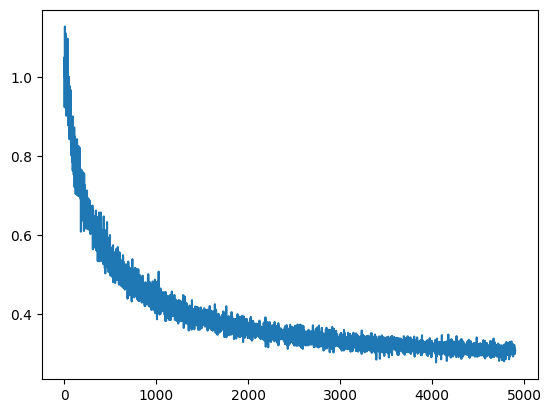

In [41]:
plt.plot(loss_history)

### Reconstruction evaluation

In [42]:
import torch
import tqdm

# Lists to store the outputs, ground truth, and masks
reconstructions = []
ground_truths = []
masks = []

# Set the model to evaluation mode
model.eval()

# Test loop to extract ground truth, reconstructions, and masks
with torch.no_grad():  # Disable gradient calculations for inference
    pbar = tqdm.tqdm(test_loader)
    
    for x, y in pbar:
        x = x.to(device)
        
        # Forward pass to get the reconstruction and mask
        output, mask = model(x, mask_ratio=0.1)
        
        # Trim output to match ground truth sequence length
        effective_seq_len = output.shape[1]
        data_trimmed = x[:, :effective_seq_len, :]
        
        # Append the results to the lists (detach from GPU and convert to CPU tensors)
        reconstructions.append(output.cpu())
        ground_truths.append(data_trimmed.cpu())
        masks.append(mask.cpu())

print("Test reconstructions, ground truth, and masks are stored in lists.")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

Test reconstructions, ground truth, and masks are stored in lists.


In [48]:
reconstructions = torch.cat(reconstructions,0)
ground_truths = torch.cat(ground_truths,0)
masks = torch.cat(masks,0)


In [60]:
# patch_size=100

In [62]:
masks_extended = torch.repeat_interleave(masks,patch_size,1)

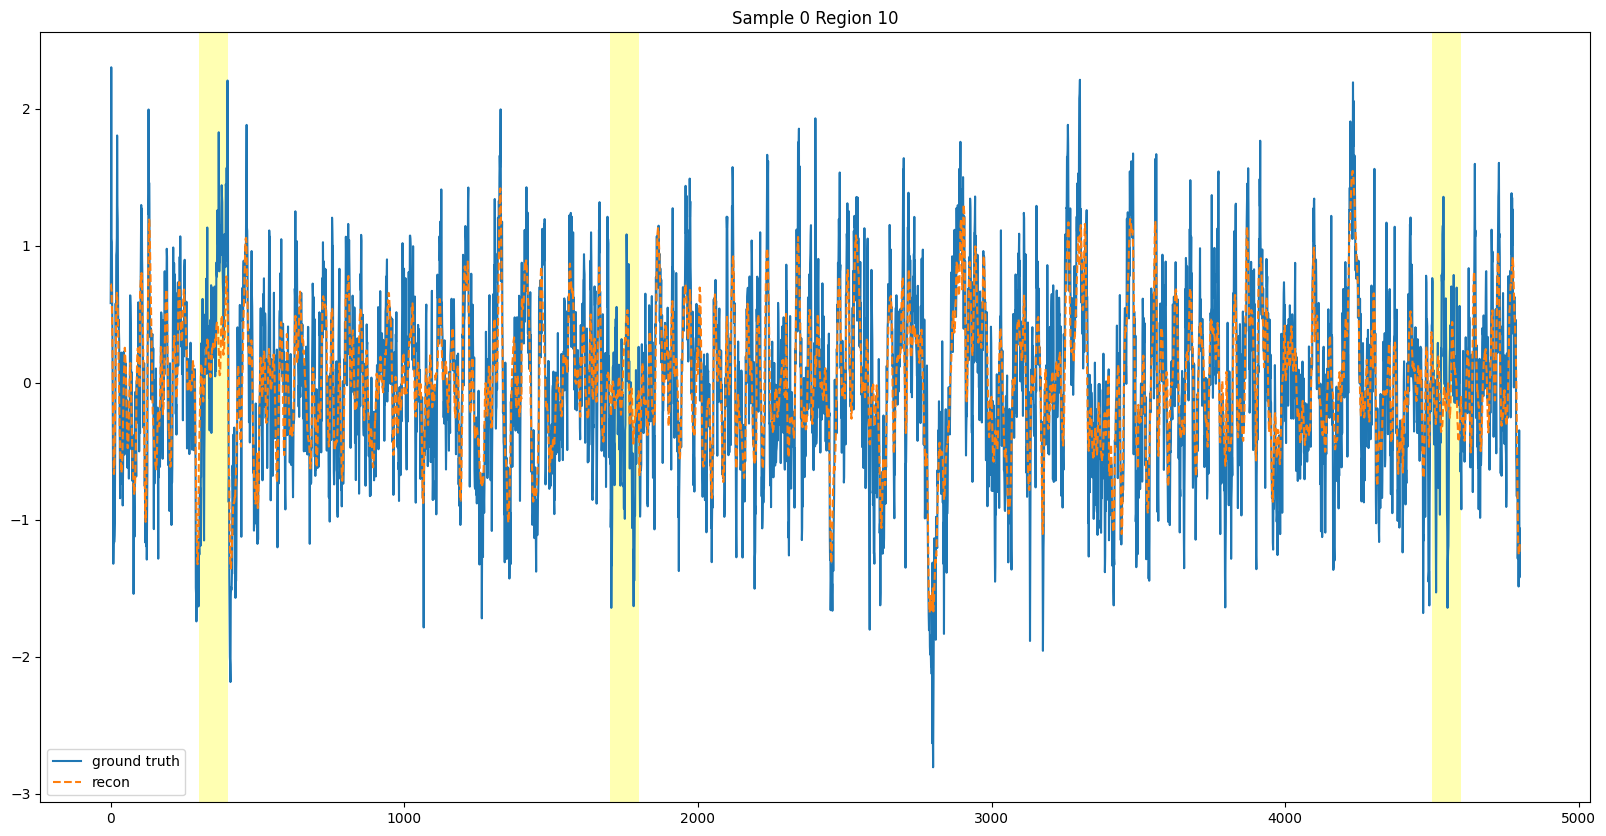

In [73]:
sample_idx = 0
region_idx = 10

fig, axs = plt.subplots(1,1, figsize = (20,10))

mask_sample = masks[sample_idx][:,region_idx]


for i, m in enumerate(mask_sample):
    
    if m.item() == 1.0:
        start = i * patch_size
        end = (i + 1) * patch_size
        if i>0:
            axs.axvspan(start, end, facecolor='yellow', alpha=0.3)

        else:
            axs.axvspan(start, end, facecolor='yellow', alpha=0.3,label="masked")
            
axs.plot(ground_truths[sample_idx, :, region_idx],label="ground truth")
axs.plot(reconstructions[sample_idx, :, region_idx],"--",label = "recon")
axs.set_title(f"Sample {sample_idx} Region {region_idx}")
axs.legend()


### Measure performances 

In [74]:
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Initialize accumulators for the metrics
r2_scores = []
pearson_correlations = []
mse_scores = []

# Loop over each sample in the batch
for i in range(ground_truths.shape[0]):
    # Flatten the ground truth and reconstructed series for the current sample
    ground_truth_flat = ground_truths[i].view(-1).cpu().numpy()
    reconstruction_flat = reconstructions[i].view(-1).cpu().numpy()

    # Compute R² for the current sample
    r2 = r2_score(ground_truth_flat, reconstruction_flat)
    r2_scores.append(r2)

    # Compute Pearson correlation for the current sample
    pearson_corr, _ = pearsonr(ground_truth_flat, reconstruction_flat)
    pearson_correlations.append(pearson_corr)

    # Compute MSE for the current sample
    mse = F.mse_loss(reconstructions[i], ground_truths[i]).item()
    mse_scores.append(mse)

# Compute the average of each metric
avg_r2 = sum(r2_scores) / len(r2_scores)
avg_pearson = sum(pearson_correlations) / len(pearson_correlations)
avg_mse = sum(mse_scores) / len(mse_scores)

# Print the average results
print(f'Average R² Score: {avg_r2:.4f}')
print(f'Average Pearson Correlation: {avg_pearson:.4f}')
print(f'Average Mean Squared Error (MSE): {avg_mse:.4f}')


Average R² Score: 0.7209
Average Pearson Correlation: 0.8524
Average Mean Squared Error (MSE): 0.2569


## Decoding Accuracy performances

### Train a supervised model to predict genre from time-series

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer


class TimeSeriesCNN(pl.LightningModule):
    def __init__(self, input_size, num_classes):
        super(TimeSeriesCNN, self).__init__()
        
        # CNN architecture using Conv1d layers for time series data
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        
        
        # Input shape: (batch_size, num_channels, sequence_length)
        x = x.permute(0,2,1)
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten the output from Conv layers
        x = torch.mean(x, dim=-1)  # Global average pooling (alternative to flatten)
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss_fn(outputs, y)
        self.log('train_loss', loss,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss_fn(outputs, y)
        acc = (outputs.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss,prog_bar=True)
        self.log('val_acc', acc,prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


In [82]:
model = TimeSeriesCNN(input_size=d_in, num_classes=2)

# Create PyTorch Lightning trainer
trainer = Trainer(max_epochs=20, devices=[1])

# Train the model
trainer.fit(model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv1d           | 4.9 K  | train
1 | conv2   | Conv1d           | 24.7 K | train
2 | conv3   | Conv1d           | 98.6 K | train
3 | pool    | MaxPool1d        | 0      | train
4 | fc1     | Linear           | 32.9 K | train
5 | fc2     | Linear           | 258    | train
6 | relu    | ReLU             | 0      | train
7 | dropout | Dropout          | 0      | train
8 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.645     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.93it/s, v_num=1, train_loss=0.689]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.83it/s, v_num=1, train_loss=0.694, val_loss=0.695, val_acc=0.493]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.88it/s, v_num=1, train_loss=0.717, val_loss=0.695, val_acc=0.493]
Validation: |                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.70it/s, v_num=1, train_loss=0.231, val_loss=0.437, val_acc=0.828]


In [86]:
from sklearn.metrics import classification_report
import torch

# Function to get predictions for the entire dataset
def predict_and_store(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in tqdm.tqdm(data_loader):
            x, y = batch
            x = x.to(model.device)  # Move data to the same device as the model
            y = y.to(model.device)
            
            # Get predictions
            outputs = model(x)
            preds = outputs.argmax(dim=1)  # Get the predicted class index
            
            # Store predictions and ground truth
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU
            all_labels.extend(y.cpu().numpy())     # Move ground truth to CPU
    
    return all_preds, all_labels


In [87]:
# Assuming `train_loader` is the DataLoader for the training set
predictions, ground_truth = predict_and_store(model, test_loader)

# Print classification report
print(classification_report(ground_truth, predictions))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       103
           1       0.76      0.94      0.84       100

    accuracy                           0.83       203
   macro avg       0.84      0.83      0.83       203
weighted avg       0.85      0.83      0.83       203



## Extract latent using the foundation model